In [1]:
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
# import pandas as ps
import time
import re
import os
import shutil
import glob
import math

# from config import config
import data_helpers
from data_generator import *

In [2]:
TEST_ID = 'UK05'
BATCH_SIZE = 16
LOSS_RAMBDA = 0.2
LEARNING_RATE = 0.000001
MAE_NOT_MCE_P_LOSS = True
TRANSFORMER_DROP = 0.1
RE_START_FROM_BATCHING = False
id_to_ids_filename = 'England-400-1e-07-7300-75-0.8-False'

In [3]:
# LR: :43/(0.00001, 1.0), (0.000002, 0.5)

In [4]:
countryDirPath = "./data/football-data-co-uk/England"
df = data_helpers.get_master_df_from_football_data_co_uk(countryDirPath)

In [5]:
tokenizer_team = creat_team_tokenizer_uk(df)
print(tokenizer_team.get_vocab_size())

teams = ['Tottenham', 'Arsenal', 'Liverpool', 'what?', 'Tottenham', 'Chelsea', 'e_t', 'Man United', '1234', '[HOME]', '[AWAY]']
teams = [team.strip() for team in [re.sub(r"\s", "_", item) for item in teams]]
teams = " ".join(teams)
encoding = tokenizer_team.encode(teams)
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)

tokenizer_team.decode(encoding.ids)

113
['tottenham', 'arsenal', 'liverpool', '[UNK]', 'tottenham', 'chelsea', '[UNK]', 'man_united', '[UNK]', '[UNK]', '[UNK]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 4, 58, 0, 101, 27, 0, 62, 0, 0, 0]


'tottenham arsenal liverpool tottenham chelsea man_united'

In [6]:
filepath = os.path.join(os.getcwd(), 'data', 'id_to_ids', id_to_ids_filename + '.json')
id_to_ids = data_helpers.LoadJsonData(filepath)

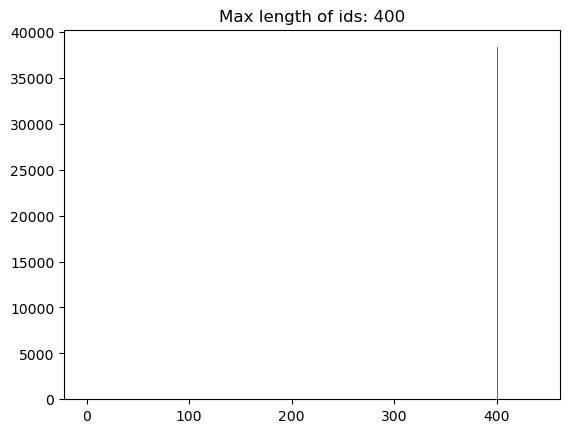

In [7]:
lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*1.1), int(maxLen*1.1) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

MAX_TOKENS = maxLen

In [8]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Result_cols = ['HTR', 'FTR']    # A function of Goal_cols, but contribute to better representation.
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols
_Cols_List_to_Embedd = [Div_cols, Team_cols, Goal_cols, Result_cols]
_Cols_List_to_Standardize = [Odds_cols, Shoot_cols, ShootT_cols, Corner_cols, Faul_cols, Yellow_cols, Red_cols]
_Cols_List_for_Label = [Full_Goal_cols, Odds_cols]
_Label_cols = Full_Goal_cols + Odds_cols

BBAB_cols = BB_cols + AB_cols
base_bbab = list(df.loc[df['id'] == 100000, BBAB_cols].iloc[0, :])
print(base_bbab)

[100000, 'E0', datetime.date(2004, 1, 11), 'Man_City', 'Norwich', 1.72, 3.4, 5.0, 1.7, 3.2, 5.0, 1.65, 3.3, 4.4, 1.66, 3.1, 5.0, 1.0, 0.0, 1, 1, 'H', 'D', 19.0, 10.0, 11.0, 5.0, 9.0, 4.0, 10.0, 13.0, 1.0, 0.0, 0.0, 0.0]


In [9]:
array = df[Red_cols]
array = np.array(array)
print(array.mean(), array.std())
array = (array - array.mean()) / array.std()
print(array)
print(array.mean(), array.std())

0.08013937282229965 0.2855927650445304
[[-0.28060715 -0.28060715]
 [-0.28060715 -0.28060715]
 [-0.28060715 -0.28060715]
 ...
 [-0.28060715 -0.28060715]
 [-0.28060715 -0.28060715]
 [-0.28060715 -0.28060715]]
-8.619307931533026e-18 1.0


In [10]:
std_path = os.path.join('./data', 'datasets', id_to_ids_filename + ".json")
std_params = get_standardization_params(df)
print(std_params)
data_helpers.SaveJsonData(std_params, std_path)
std_params = data_helpers.LoadJsonData(std_path)

{'B365H': (3.1630270400481795, 1.4687447460469159, 46.0), 'HS': (11.39694154084398, 4.709404811489129, 43.0), 'HST': (4.815343915343916, 2.759941394538306, 24.0), 'HC': (5.34632855852368, 2.842282967456132, 24.0), 'HF': (11.421925409730287, 3.7612036770331043, 77.0), 'HY': (1.5455413601755066, 1.2348960213340971, 11.0), 'HR': (0.08013937282229965, 0.2855927650445304, 3.0)}


In [11]:
ds_path = os.path.join('./data', 'datasets', id_to_ids_filename)

# ds = generate_dataset_uk(df, id_to_ids, tokenizer_team, std_params)
# tf.data.Dataset.save(ds, ds_path)

ds = tf.data.Dataset.load(ds_path)
len(ds)

38745

In [12]:
cnt = 600
for (baseId, sequence, base_bb, base_label) in ds:
    cnt -= 1
    if cnt == 0:
        print(baseId)
        print(sequence[0])
        break
# [div 4, teams 8, odds 12, goals 16, results 8, Shoot 2, ShootT 2;    Corner 2, Faul 2, Yellow 2, Red 2]
# 0 Yellows -> -1.25, 0 Reds -> -.2806

tf.Tensor(128479, shape=(), dtype=int32)
tf.Tensor(
[ 1.2847000e+05  4.0000000e+00  1.7490000e+03  2.3000000e+01
  7.0000000e+01 -5.1950961e-01  5.9215844e-02 -3.6972186e-01
 -5.8759499e-01  2.5173169e-02 -3.4929624e-01 -4.8546696e-01
 -1.1099753e-01 -4.8546696e-01 -4.5142427e-01 -4.2912181e-02
 -4.5142427e-01  0.0000000e+00  1.0000000e+00  0.0000000e+00
  1.0000000e+00  3.0000000e+00  3.0000000e+00 -7.2131014e-01
 -7.2131014e-01 -2.9542074e-01 -6.5774727e-01 -8.2550842e-01
 -4.7367859e-01  4.1956636e-01  4.1956636e-01 -4.4177109e-01
  1.1777985e+00 -2.8060716e-01 -2.8060716e-01], shape=(35,), dtype=float32)


In [13]:
TRAIN_PERCENT= 90

In [14]:

dataset_size = len(ds)
train_size = int(TRAIN_PERCENT/100 * dataset_size)
test_size = dataset_size - train_size

train_ds = ds.take(train_size)
test_ds = ds.skip(train_size)

print(len(train_ds), len(test_ds), len(ds), len(ds)-len(train_ds)-len(test_ds))

34870 3875 38745 0


In [15]:
BUFFER_SIZE = 20000

In [16]:
dummy_bbas_tensor = get_dummy_bbas_tensor_uk(df, tokenizer_team, std_params)

In [17]:
def normalize_row(baseId, sequence, base_bb, base_label):
    try:
        seq_len_org = sequence.shape[0]
        nMissings = MAX_TOKENS - seq_len_org    # MAX_TOKENS - tf.shape(sequence)[0].numpy()
        if nMissings > 0:
            block = tf.stack([dummy_bbas_tensor] * nMissings, axis=0)
            sequence = tf.concat([sequence, block], axis=0) 
        # print("sequence 1", sequence.shape)
        # sequence[:, 2] = base[2] - sequence[:, 2]   # get delta days.
        base_bb = base_bb[tf.newaxis, :]    # shape: (seq_len = 1, nFeatures)
        mask = tf.Variable([1] * seq_len_org + [0] * nMissings, dtype=tf.int32) ## DO NOT USE tf.constant !!! unstable.
        mask = mask[:, tf.newaxis] & mask[tf.newaxis, :]
        # print('normalize', sequence.shape, base.shape, mask.shape, mask)
        # seq_len_org = tf.Variable(seq_len_org, dtype=tf.int32)    #--------------------------------- comeback
        return (baseId, sequence, base_bb, base_label, mask, seq_len_org)
    except:
        print('normalize_row exception')
        print('norm 1', sequence.shape, base_bb.shape, base_label.shape, mask.shape, nMissings)
        print('norm 2', baseId, sequence, base_label, mask, nMissings)
        # return (baseId, sequence, base_bb, base_label, mask, seq_len_org)

In [18]:
cnt = 600
for (baseId, sequence, base_bb, base_label) in train_ds:
    z = normalize_row(baseId, sequence, base_bb, base_label)
    cnt -= 1
    if cnt == 0:
        print(baseId)
        print(sequence[0])
        break
# [div 4, teams 8, odds 12, goals 16, results 8, Shoot 2, ShootT 2;    Corner 2, Faul 2, Yellow 2, Red 2]
# 0 Yellows -> -1.25, 0 Reds -> -.2806

tf.Tensor(128479, shape=(), dtype=int32)
tf.Tensor(
[ 1.2847000e+05  4.0000000e+00  1.7490000e+03  2.3000000e+01
  7.0000000e+01 -5.1950961e-01  5.9215844e-02 -3.6972186e-01
 -5.8759499e-01  2.5173169e-02 -3.4929624e-01 -4.8546696e-01
 -1.1099753e-01 -4.8546696e-01 -4.5142427e-01 -4.2912181e-02
 -4.5142427e-01  0.0000000e+00  1.0000000e+00  0.0000000e+00
  1.0000000e+00  3.0000000e+00  3.0000000e+00 -7.2131014e-01
 -7.2131014e-01 -2.9542074e-01 -6.5774727e-01 -8.2550842e-01
 -4.7367859e-01  4.1956636e-01  4.1956636e-01 -4.4177109e-01
  1.1777985e+00 -2.8060716e-01 -2.8060716e-01], shape=(35,), dtype=float32)


In [19]:
class hyperparams:    
    nDivisions = 4 + 1  # E0, E1, E2, E3, and Unknown
    division_embs = 4
    nTeams = tokenizer_team.get_vocab_size()    # including Unknown
    team_embs = 50
    nGoals  = 10  # 0..9. 0 for 0 goals not for Unknown.
    goal_embs = 4
    nResults = 4    # HWin, Draw, AWin, and Unknown
    result_embs = 4
    # Mate d_model an even number!!!
    d_model = get_std_size()    + division_embs * len(Div_cols) + team_embs * len(Team_cols) \
                                + goal_embs * len(Goal_cols) + result_embs * len(Result_cols)
    batch_size = BATCH_SIZE
    max_tokens = MAX_TOKENS
    days_spanning_years = 30
    num_heads = 10
    num_layers = 6
    memory_365_size = 10
    # d_model = team_emb_size * 2 + country_emb_size * 3 + odds_size + outcome_size


In [20]:
def prepare_batch(baseId, sequence, base_bb, base_label, mask, seq_len_org):
    # target = tf.one_hot(tf.squeeze(tf.cast(base_bbab[:, :, -1], dtype=tf.int32), axis=-1), hyperparams.target_onehot_size)
    
    return (baseId, sequence, base_bb, mask), (base_label, seq_len_org)     # (X, Y)

In [21]:
def make_batches(ds):
    return (
        ds
        .shuffle(BUFFER_SIZE)
        .map(lambda baseId, sequence, base_bb, base_label: tf.py_function(
            func=normalize_row,
            inp=[baseId, sequence, base_bb, base_label],
            Tout=[tf.int32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32])) #, tf.data.AUTOTUNE == Instability!!!
        .batch(BATCH_SIZE)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )
# Normalize_row
# In: baseId, sequence, base_bb, base_label
# Out: baseId, sequence, base_bb, base_label, mask, seq_len_org

In [22]:
train_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename + '_train_batch_' + TEST_ID)

if RE_START_FROM_BATCHING:
    if os.path.exists(train_ds_path):
        shutil.rmtree(train_ds_path)
        # os.remove(train_ds_path)  # Access denied
    print('Creating train batch dataset...', end='')
    train_batches = make_batches(train_ds)
    tf.data.Dataset.save(train_batches, train_ds_path)
    print('done')
else:
    try:
        train_batches = tf.data.Dataset.load(train_ds_path)
    except:
        print('Creating train batch dataset...', end='')
        train_batches = make_batches(train_ds)
        tf.data.Dataset.save(train_batches, train_ds_path)
        print('done')

In [23]:
test_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename + '_test_batch_' + TEST_ID)

if RE_START_FROM_BATCHING:
    if os.path.exists(test_ds_path):
        shutil.rmtree(test_ds_path)
        # os.remove(test_ds_path)   # Access denied
    print('Creating test batch dataset...', end='')
    test_batches = make_batches(test_ds)
    tf.data.Dataset.save(test_batches, test_ds_path)
    print('done')
try:
    test_batches = tf.data.Dataset.load(test_ds_path)
except:
    print('Creating test batch dataset...', end='')
    test_batches = make_batches(test_ds)
    tf.data.Dataset.save(test_batches, test_ds_path)
    print('done')

In [24]:
def positional_encoding(memory, depth):
    positions = tf.range(memory.shape[-1], dtype=tf.float32)
    fractional_pos = memory * positions    # fractional position: (batch, fractional position #)
    depth = depth/2
    depths = tf.range(depth, dtype=tf.float32) / depth
    depths = tf.pow(10000.0, depths)    # (depth,)
    angle_rads = fractional_pos[:, :, tf.newaxis] / depths  # (batch, fractional position #, depth)
    # pos_encoding = rearrange([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], 'w b p d -> w h (w t)')
    pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)
    return pos_encoding

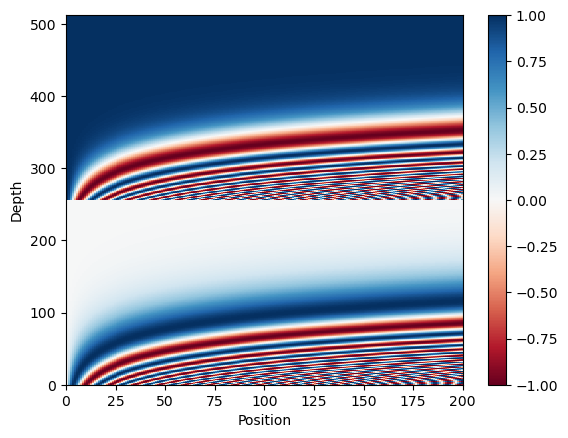

In [25]:
memory = tf.ones((100, 200), dtype=tf.float32) * 0.5
pos_encoding = positional_encoding(memory, depth=512)
# print('pos_encoding', pos_encoding.shape)
pos_encoding = pos_encoding[0, :, :]
# print(pos_encoding.shape)
# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [26]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Result_cols = ['HTR', 'FTR']    # A function of Goal_cols, but contribute to better representation.
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

In [27]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, hyperparams, isEncoder=True):
    super().__init__()
    self.isEncoder = isEncoder
    self.division_embedding = tf.keras.layers.Embedding(hyperparams.nDivisions, hyperparams.division_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
    self.team_embedding = tf.keras.layers.Embedding(hyperparams.nTeams, hyperparams.team_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
    self.goal_embedding = tf.keras.layers.Embedding(hyperparams.nGoals, hyperparams.goal_embs, dtype=tf.float32, mask_zero=False) # Learn 0-goal
    self.result_embedding = tf.keras.layers.Embedding(hyperparams.nResults, hyperparams.result_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown

    self.d_model = hyperparams.d_model
    # print(self.d_model)
    self.position_permuting_dense = tf.keras.layers.Dense(self.d_model)
    vocab_size = 1 + 1 # 1 for padding, 1 for our parameters.
    self.memory_365_embedding = tf.keras.layers.Embedding(vocab_size, hyperparams.memory_365_size, mask_zero=False, embeddings_initializer = tf.keras.initializers.Ones())

    self.idx_Days = BB_cols.index('Date')
    assert self.idx_Days == BBAB_cols.index('Date')

  def call(self, x):
    # print('x', x[0].shape, x[1].shape)
    (sequence, base_bb, mask) = x # sob = sequence or base_bb
    sDays = sequence[:, :, self.idx_Days]
    bDays = base_bb[:, :, self.idx_Days]
    # print('days shapes', days.shape)
    
    # BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
    # AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

    sob = None
    if self.isEncoder:
      sob = sequence
    else:
      sob = base_bb

    if self.isEncoder:
      id, div, days, teams, odds, goals, results, remainder \
      = tf.split(sob, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), len(Goal_cols), len(Result_cols),  -1], axis=-1)
      # print('1', remainder[0, 0])
    else:
      id, div, days, teams, remainder \
      = tf.split(sob, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), -1], axis=-1)  
      # print('2', remainder[0, 0])  

    div = self.division_embedding(tf.cast(div, dtype=tf.int32))
    div = tf.reshape(div, [div.shape[0], div.shape[1], -1])
    teams = self.team_embedding(tf.cast(teams, dtype=tf.int32))
    teams = tf.reshape(teams, [teams.shape[0], teams.shape[1], -1])
    if self.isEncoder:
      goals = self.goal_embedding(tf.cast(goals, dtype=tf.int32))
      goals = tf.clip_by_value(goals, 0, hyperparams.nGoals)
      goals = tf.reshape(goals, [goals.shape[0], goals.shape[1], -1])
      results = self.result_embedding(tf.cast(results, dtype=tf.int32))
      results = tf.reshape(results, [results.shape[0], results.shape[1], -1])
    
    if self.isEncoder:
      concat = [div, teams, odds, goals, results, remainder]
      # print('10', div.shape, teams.shape, odds.shape, goals.shape, results.shape, remainder.shape)
      # print('11', remainder[0,0])
    else:
      concat = [div, teams, remainder]
      # print('22', remainder[0,0])

    sob = tf.concat(concat, axis=-1)
    sob = self.position_permuting_dense(sob)  #====================================================
    # print('33', sob[0][0])

    days_ago = tf.cast(bDays - sDays, dtype=tf.float32) if self.isEncoder else tf.cast(bDays - bDays, dtype=tf.float32)
    # print('days_ago', days_ago.shape) # (batch, seq_len)
    # Do not use tf.zeros, because it's padding token and gives zeros.
    initial_memory_365 = 0.8
    memory_365 = self.memory_365_embedding(tf.ones_like((hyperparams.memory_365_size,), dtype=tf.float32)) * initial_memory_365  # expected shape: (1, hyperparams.remain_365_size,)
    memory_365 = tf.squeeze(memory_365, axis=0)
    # print('memory_365 1', memory_365.shape, memory_365) # (hyperparams.memory_365,)
    # It may be disastrous if some of remain_365 gets larger than 1. 
    memory_365 = tf.clip_by_value(memory_365, 0.01, 1.0)  # Is clip differentiable?
    # print('remmemory_365 2', memory_365.shape) # (hyperparams.memory_365,)
    # print('memory_365', memory_365)
    alpha = tf.math.pow(memory_365, -1.0/365) # (hyperparams.memory_365,)
    memory = tf.math.pow(alpha, -days_ago[:, :, tf.newaxis])  # decrease as days_ago increase.  memory <= 1.0
    # print('memory org', memory.shape) # (batch, max_seq_len, hyperparams.memory_365)
    # print('memory[0,0,:]', memory[0, 0, :])
    memory = tf.reduce_mean(memory, axis=-1)
    # print('memory', memory.shape) # (batch, max_seq_len)

    pe = positional_encoding(memory, depth=sob.shape[-1])
    # print('x, pe, d_model', x.shape, pe.shape, self.d_model)

    # This factor sets the relative scale of the embedding and positonal_encoding.
    pe = pe / tf.math.sqrt(tf.cast(sob.shape[-1], tf.float32)) #=================================

    sob = sob + pe  # comeback

    if self.isEncoder:
      mask = mask
    else:
      mask = mask[:, 0:sob.shape[1], :]

    return (sob, mask)

In [28]:
pos = PositionalEmbedding(hyperparams, isEncoder=True)

cnt = 2
for z in train_batches:
    (baseId, sequence, base_bb, mask), (base_label, seq_len_org) = z
    cnt -= 1
    if cnt == 0: break
# print('baseId', baseId)
x = (sequence, base_bb, mask)
eSob, eMask = pos.call(x)
print(eSob.shape, eMask.shape)

(16, 400, 152) (16, 400, 400)


In [29]:
ws = pos.get_weights()
shapes = [w.shape for w in ws]
print(shapes)
del pos
# div (nDiv, embs), (nTeam, embs), (nGoals, embs), (nResults, embs), 
# (position_permuting_dense: d_model, d_model), (???: d_model,), (memory_365_embedding: 2, memory_365_size)

[(5, 4), (113, 50), (10, 4), (4, 4), (152, 152), (152,), (2, 10)]


In [30]:
pos = PositionalEmbedding(hyperparams, isEncoder=False)

cnt = 1
for z in train_batches:
    (baseId, sequence, base_bb, mask), (base_label, seq_len_org) = z
    cnt -= 1
    if cnt == 0: break
x = (sequence, base_bb, mask)
dSob, dMask = pos.call(x)
print(dSob.shape, dMask.shape)

(16, 1, 152) (16, 1, 400)


In [31]:
ws = pos.get_weights()
shapes = [w.shape for w in ws]
print(shapes)
del pos
# div (nDiv, embs), (nTeam, embs), 
# (position_permuting_dense: d_model, d_model), (???: d_model,), (memory_365_embedding: 2, memory_365_size)

[(5, 4), (113, 50), (116, 152), (152,), (2, 10)]


In [32]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()   # So the default -1 axix is normalized across. No inter-token operatoin.
    self.add = tf.keras.layers.Add()

In [33]:
class CrossAttention(BaseAttention):
  def call(self, x, context, mask):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        attention_mask=mask,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [34]:
PE = PositionalEmbedding(hyperparams, isEncoder=True)
eSob, eMask = PE(x)
print(eSob.shape, eMask.shape )

(16, 400, 152) (16, 400, 400)


In [35]:
PE = PositionalEmbedding(hyperparams, isEncoder=False)
dSob, dMask = PE(x)
print(dSob.shape, dMask.shape )

(16, 1, 152) (16, 1, 400)


In [36]:
sample_ca = CrossAttention(num_heads=2, key_dim=hyperparams.d_model)
print(sample_ca(dSob, eSob, dMask).shape)

(16, 1, 152)


In [37]:
class GlobalSelfAttention(BaseAttention): 
  def call(self, x, mask):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        attention_mask=mask)    # intentional inter-token operation
    x = self.add([x, attn_output])  # token-wise
    x = self.layernorm(x)         # normalize across the default -1 axis. No inter-token operatoin.
    return x

In [38]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=hyperparams.d_model)
print(sample_gsa(eSob, eMask).shape)
del sample_gsa

(16, 400, 152)


In [39]:
class CausalSelfAttention(BaseAttention): # mask-agnostic
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)     # look-over mask is generagted and used, in decoder layers
    x = self.add([x, attn_output])  # mask-agnostic
    x = self.layernorm(x)  # normalize across the default -1 axis. No inter-token operatoin.
    return x

In [40]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=hyperparams.d_model)
print(sample_csa(dSob).shape)
del sample_csa

(16, 1, 152)


In [41]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),    # across -1 axis
      tf.keras.layers.Dense(d_model),    # across -1 axis
      tf.keras.layers.Dropout(dropout_rate)    # mask-agnostic
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])  # mask-agnostic
    x = self.layer_norm(x)  # normalize across the default -1 axis. No inter-token operatoin.
    return x

In [42]:
sample_ffn = FeedForward(hyperparams.d_model, hyperparams.d_model * 4)
print(sample_ffn(eSob).shape)
del sample_ffn

(16, 400, 152)


In [43]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, mask):
    x = self.self_attention(x, mask)
    x = self.ffn(x)
    return x

In [44]:
sample_encoder_layer = EncoderLayer(d_model=hyperparams.d_model, num_heads=hyperparams.num_heads, dff=hyperparams.d_model * 4)
print(sample_encoder_layer(eSob, eMask).shape)
del sample_encoder_layer

(16, 400, 152)


In [45]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, hyperparams, dropout_rate=0.1):
    super().__init__()

    self.d_model = hyperparams.d_model
    self.num_layers = hyperparams.num_layers

    self.pos_embedding = PositionalEmbedding(hyperparams)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.enc_layers = [
        EncoderLayer(d_model=hyperparams.d_model,
                     num_heads=hyperparams.num_heads,
                     dff=hyperparams.d_model * 4,
                     dropout_rate=dropout_rate)
        for _ in range(hyperparams.num_layers)]

  def call(self, x):
    x, mask = self.pos_embedding(x)  # output Shape `(batch_size, seq_len, d_model)`.

    x = self.dropout(x)
    for encoder_layer in self.enc_layers:
      x = encoder_layer(x, mask)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [46]:
sample_encoder = Encoder(hyperparams)
for z in train_batches:
    (baseId, sequence, base_bb, mask), (base_label, seq_len_org) = z
    x = (sequence, base_bb, mask)
    sample_encoder_output = sample_encoder(x)
    print(sample_encoder_output.shape)
    break
del sample_encoder

(16, 400, 152)


In [47]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context, cross_attention_mask):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x, context, cross_attention_mask)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [48]:
sample_decoder_layer = DecoderLayer(d_model=hyperparams.d_model, num_heads=hyperparams.num_heads, dff=hyperparams.d_model * 4)
print(sample_decoder_layer(dSob, eSob, eMask).shape)
del sample_decoder_layer

(16, 400, 152)


In [49]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, hyperparams, dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = hyperparams.d_model
    self.num_layers = hyperparams.num_layers

    self.pos_embedding = PositionalEmbedding(hyperparams, isEncoder=False)

    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=hyperparams.d_model, num_heads=hyperparams.num_heads,
                     dff=hyperparams.d_model * 4, dropout_rate=dropout_rate)
        for _ in range(hyperparams.num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x, cross_attention_mask = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)
    # print('decoder input x, cross_attention_mask', x.shape, cross_attention_mask.shape)
    
    x = self.dropout(x)
    for decoder_layer in self.dec_layers:
      x  = decoder_layer(x, context, cross_attention_mask)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [50]:
sample_decoder = Decoder(hyperparams)
for z in train_batches:
    (baseId, sequence, base_bb, mask), (base_label, seq_len_org) = z
    x = (sequence, base_bb, mask)
    break
print(sample_decoder(x, eSob).shape)
del sample_decoder

(16, 1, 152)


In [51]:
class Transformer(tf.keras.Model):
  def __init__(self, hyperparams, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(hyperparams, dropout_rate=dropout_rate)

    self.decoder = Decoder(hyperparams, dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(hyperparams.d_model) #-------------- to modify

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    # context = inputs
    # x = inputs

    # print('transformer, inputs', len(inputs), inputs[0].shape, inputs[1].shape, tf.rank(inputs[0]), tf.rank(inputs[1]))
    # print('transformer, inputs', len(inputs), tf.shape(inputs[0]), tf.shape(inputs[1]), tf.rank(inputs[0]), tf.rank(inputs[1]))
    x = self.encoder(inputs)  # (batch_size, context_len, d_model)
    # print('transformer, encoder out', x.shape)
    # print('transformer, decoder input', inputs[0].shape, inputs[1].shape, inputs[2].shape)
    x = self.decoder(inputs, x)  # (batch_size, target_len, d_model)
    # print('transformer, decoder out', x.shape)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len=1, target_vocab_size)
    logits = tf.squeeze(logits, axis=-2)
    # print('transformer, logits', logits.shape)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits
  
  def train_step(self, data):
      # Unpack the data. Its structure depends on your model and
      # on what you pass to `fit()`.
      x, y = data

      # print('train_step', x[0].shape, x[1].shape)

      with tf.GradientTape() as tape:
          y_pred = self(x, training=True)  # Forward pass
          # Compute the loss value
          # (the loss function is configured in `compile()`)
          loss = self.compute_loss(y=y, y_pred=y_pred)

      # Compute gradients
      trainable_vars = self.trainable_variables
      gradients = tape.gradient(loss, trainable_vars)
      # Update weights
      self.optimizer.apply_gradients(zip(gradients, trainable_vars))
      # Update metrics (includes the metric that tracks the loss)
      for metric in self.metrics:
          if metric.name == "loss":
              metric.update_state(loss)
          else:
              metric.update_state(y, y_pred)
      # Return a dict mapping metric names to current value
      return {m.name: m.result() for m in self.metrics}

In [52]:
sample_transformer = Transformer(hyperparams)
for z in train_batches:
    (baseId, sequence, base_bb, mask), (base_label, seq_len_org) = z
    x = (sequence, base_bb, mask)
    break
x = (sequence, base_bb, mask)
y = sample_transformer(x)

sample_transformer.summary()
del sample_transformer

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  6719434   
                                                                 
 decoder_1 (Decoder)         multiple                  12288962  
                                                                 
 dense_62 (Dense)            multiple                  23256     
                                                                 
Total params: 19,031,652
Trainable params: 19,031,652
Non-trainable params: 0
_________________________________________________________________


In [53]:
class Adaptor(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),    # across -1 axis
      tf.keras.layers.Dense(d_model),    # across -1 axis
      tf.keras.layers.Dropout(dropout_rate)    # mask-agnostic
    ])
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.seq(x)
    x = self.layer_norm(x)  # Do we need this?
    return x

In [54]:
class QGroup(tf.keras.Model):
  softmax = tf.keras.layers.Softmax(axis=-1)
  scalar_product = tf.keras.layers.Dot(axes=(-1, -1))

  def __init__(self, bookie, nQueries, dropout_rate=0.1):
    super().__init__()
    self.bookie = bookie
    self.nQueries = nQueries
    self.bookieBase = Adaptor(self.nQueries, self.nQueries * 4)
    self.oh_1 = Adaptor(self.nQueries, self.nQueries * 4)

    return
    
  def call(self, input):
    # inputs.shape: (batch, d_model)
    base = self.bookieBase(input)        # (batch, nQueries)
    stake_p = QGroup.softmax(base)            # (batch, nQueries)
    oh_1_p = self.oh_1(base)                  # (batch, nQueries)
    # profit_p = QGroup.scalar_product([oh_1_p, stake_p])   # (batch, 1)
    profit_p = tf.math.multiply(oh_1_p, stake_p)   # (batch, nQueries)

    return (profit_p, stake_p)  # (batch, nQueries), (batch, nQueries) 
  
  #----- ToDo: replace self.scalar_product layer with a tf scalar product function, for speed.
  def h_true(ftGoals):  # Defines this QGroup. This is for 1X2 QGroup. Derived classes re-define this funciton.
    # ftGoals:  (batch, 2)
    ftGoals = tf.cast(ftGoals, dtype=tf.int32)  # (batch, 2)
    h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
    h = tf.cast(tf.transpose(h), dtype=tf.float32)  # (batch, nQueries)
    return h
  
  def stake_true(ftGoals):
    return QGroup.h_true(ftGoals)   # (batch, nQueries)
  
  def profit_true(ftGoals, odds):
    stake_t = QGroup.stake_true(ftGoals)  # (batch, nQueries)
    oh_1_true = tf.math.multiply(odds, QGroup.h_true(ftGoals)) - 1.0  # (batch, nQueries)
    profit_t = QGroup.scalar_product([oh_1_true, stake_t])  # (batch, nQueries)
    return profit_t

  def loss(profit_p, stake_p, ftGoals, odds, rambda):
    # profit_p: (batch, nQueries)
    # stake_p:  (batch, nQueries)
    # ftGoals:  (batch, 2)
    # odds:     (batch, nQueries)
    # rambda:   ()
    stake_t = QGroup.stake_true(ftGoals)  # (batch, nQueries)
    oh_1_t = tf.math.multiply(odds, QGroup.h_true(ftGoals)) - 1.0   # (batch, nQueries)

    if MAE_NOT_MCE_P_LOSS:
      profit_t = QGroup.scalar_product([oh_1_t, stake_t])   # (batch, 1)
      profit_p_errpr = tf.reduce_mean(tf.abs(profit_t - profit_p), axis=None)
    else:
      profit_t = tf.math.multiply(oh_1_t, stake_t)   # (batch, nQueries)   
      profit_mce = tf.nn.softmax_cross_entropy_with_logits(labels=profit_t, logits=profit_p)
      profit_p_errpr = tf.reduce_mean(profit_mce) # mean rather than sum, like profit_eval

    profit_eval = tf.reduce_mean(QGroup.scalar_product([oh_1_t, stake_p]), axis=None)  # ()
    loss = (1.0-rambda) * profit_p_errpr - profit_eval * rambda # ()
    return loss # ()

  def profit_true_sum(ftGoals, odds):
    stake_t = QGroup.stake_true(ftGoals)
    oh_1_true = tf.math.multiply(odds, QGroup.h_true(ftGoals)) - 1.0
    profit_t = tf.reduce_sum(QGroup.scalar_product([oh_1_true, stake_t]), axis=None)
    return profit_t

  def profit_true_sum(self, ftGoals, odds):
    stake_t = self.stake_true(ftGoals)
    oh_1_true = tf.math.multiply(odds, self.h_true(ftGoals)) - 1.0
    profit_t = tf.reduce_sum(self.scalar_product([oh_1_true, stake_t]), axis=None)
    return profit_t

  def profit_eval_sum(ftGoals, odds, stake_p):
    oh_1_t = tf.math.multiply(odds, QGroup.h_true(ftGoals)) - 1.0
    profit_e_sum = tf.reduce_sum(QGroup.scalar_product([oh_1_t, stake_p]), axis=None)
    return profit_e_sum

  def profit_eval(ftGoals, odds, stake_p):
    oh_1_t = tf.math.multiply(odds, QGroup.h_true(ftGoals)) - 1.0
    profit_e = QGroup.scalar_product([oh_1_t, stake_p])
    return profit_e

In [55]:
class QGroup1X2(QGroup):
  def __init__(self, bookie, dropout_rate=0.1):
    super().__init__(bookie=bookie, nQueries=3, dropout_rate=dropout_rate)
    self.qGroupName = '1X2'

  def h_true(ftGoals):  # Defines this QGroup. This is for 1X2 QGroup.
    # ftGoals:  (batch, 2)
    ftGoals = tf.cast(ftGoals, dtype=tf.int32)  # (batch, 2)
    h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
    h = tf.cast(tf.transpose(h), dtype=tf.float32)  # (batch, nQueries)
    return h

In [56]:
OXT = QGroup1X2('B365')
input = tf.Variable([[1,2,3], [4,5,6]], dtype=tf.float32)
OXT.call(input)
del OXT

In [57]:
ftGoals = tf.Variable([[2,3], [0,0]])
QGroup.h_true(ftGoals)
# manual:: [[0 0 1], [0 1 0]]

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [58]:
ftGoals = tf.Variable([[2,3], [0,0]])
QGroup.stake_true(ftGoals)
# manual: [[0 0 1], [0 1 0]]

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0., 0., 1.],
       [0., 1., 0.]], dtype=float32)>

In [59]:
profit_p = tf.Variable([2], dtype=tf.float32)
stake_p = tf.Variable([[0.5, 0.2, 0.3]], dtype=tf.float32)
ftGoals = tf.Variable([[2, 3]])      
odds = tf.Variable([[3, 4, 5]], dtype=tf.float32)
rambda = tf.Variable(1, dtype=tf.float32)
QGroup.loss(profit_p, stake_p, ftGoals, odds, rambda)
# manual: 1.5 if not using MCE

<tf.Tensor: shape=(), dtype=float32, numpy=-0.50000006>

In [60]:
profit_p = tf.Variable([[2, 3, 1], [1, 2, 3]], dtype=tf.float32)
stake_p = tf.Variable([[0.5, 0.2, 0.3], [0.1, 0.2, 0.7]], dtype=tf.float32)
ftGoals = tf.Variable([[2, 3], [3, 2]])
odds = tf.Variable([[3, 4, 5], [5, 4, 3]], dtype=tf.float32)
rambda = tf.Variable(1, dtype=tf.float32)
QGroup.loss(profit_p, stake_p, ftGoals, odds, rambda)
# manual: 1.5 if not using MCE

<tf.Tensor: shape=(), dtype=float32, numpy=-2.9802322e-08>

In [61]:
ftGoals = tf.Variable([[2,3], [3,3]])
odds = tf.Variable([[1,2,3], [3,4,5]], dtype=tf.float32)
stake_p = tf.Variable([[0.7, 0.2, 0.1], [0.5, 0.3, 0.2]])
QGroup.profit_eval_sum(ftGoals, odds, stake_p)
# manual: 0.5 if not using MCE

<tf.Tensor: shape=(), dtype=float32, numpy=-0.49999994>

In [62]:
class BettingEPL(tf.keras.Model):
  def __init__(self, hyperparams, loss_rambda=1.0, dropout_rate=0.1):
    super().__init__()
    self.transformer = Transformer(hyperparams, dropout_rate=dropout_rate)
    self.bookies = ['B365', 'Betfair', 'Interwetten', 'William']
    self.qGroups = [QGroup1X2(bookie) for bookie in self.bookies]
    self.rambda = loss_rambda     #----------------------- Sensitive rambda!!!, Automate optimizing it.

  def call(self, input):
    x = self.transformer(input)
    outputs = [qGroup(x) for qGroup in self.qGroups]
    return outputs  # [ ( shape: (batch, 1), shape: (batch, nQueries) ) for _ in self.qGroups ]
  
  def loss(self, y, outputs):   
    # y: (batch, len(Team_cols)+len(Odds_cols)) 
    # outputs: # [ ( shape: (batch, 1), shape: (batch, nQueries) ) for _ in self.qGroups ]
    ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, sum[qGropu.nQueries for qGroup in self.qGroups])
    odds_by_qGroup = tf.split(odds, [qQroup.nQueries for qQroup in self.qGroups], axis=-1)  # [ shape: (batch, qGroup.nQueries) for qGroup in self.qGroups ]
    losses = [QGroup.loss(profit_p, stake_p, ftGoals, odds, self.rambda) for (odds, (profit_p, stake_p)) in zip(odds_by_qGroup, outputs)]
    loss_value = tf.add_n(losses)
    return loss_value
  
  def back_test(self, y, outputs):
    # y: (batch, len(Team_cols)+len(Odds_cols)) 
    # outputs: # [ ( shape: (batch, nQueries), shape: (batch, nQueries) ) for _ in self.qGroups ]
    ftGoals, odds = tf.split(y, [2, -1], axis=-1)
    odds_by_qGroup = tf.split(odds, [qQroup.nQueries for qQroup in self.qGroups], axis=-1)
    profit_eval = [QGroup.profit_eval(ftGoals, odds, stake_p) for (odds, (_, stake_p)) in zip(odds_by_qGroup, outputs)]
    profit_eval = tf.concat(profit_eval, axis=-1) # (batch, nQGroups)
    profits_p = [tf.math.reduce_sum(profit_p, axis=-1, keepdims=True) for (profit_p, _) in outputs]   # [ shape: (batch, 1) for _ self.qGroups ]
    profits_p = tf.concat(profits_p, axis=-1) # (batch, len(self.qGroups))
    bestQuery = tf.cast(tf.argmax(profits_p, axis=-1), dtype=tf.int32)   # (batch,)
    range = tf.range(bestQuery.shape[0], dtype=tf.int32) # (batch,)
    best_idx = tf.stack([range, bestQuery], axis=1) # (batch, 2)
    best_profits_eval = tf.gather_nd(profit_eval, best_idx)  # (batch, )
    profit_eval_mean = tf.math.reduce_mean(best_profits_eval)
    return profit_eval_mean

In [63]:
EPL = BettingEPL(hyperparams, loss_rambda = LOSS_RAMBDA, dropout_rate=TRANSFORMER_DROP)
for z in train_batches:
    (baseId, sequence, base_bb, mask), (base_label, seq_len_org) = z
    x = (sequence, base_bb, mask)
    print(sequence.shape)
    break
x = (sequence, base_bb, mask)
y = EPL(x, training=True)
print(len(y))
print(len(y[0]))
(profit_p, stake_p) = y[0]
print(profit_p.shape, stake_p.shape)
print(profit_p, stake_p)   # profit_p tend to have the same sign in the same batch.

EPL.summary()

(16, 400, 35)
4
2
(16, 3) (16, 3)
tf.Tensor(
[[-0.2811082   0.07932057 -0.36312824]
 [ 0.          0.          0.        ]
 [-0.81626076  0.04919887  0.19316925]
 [-0.48271137  0.08537764 -0.17357942]
 [ 1.0324205  -0.14314261 -0.04161741]
 [-1.0802687   0.04583404  0.10795354]
 [-0.82661486  0.04881026  0.19292484]
 [-0.08587915  0.5456662   0.14318241]
 [-1.0595251   0.04786868  0.11942956]
 [-0.48293558 -0.01707478  0.08150417]
 [-0.9944344   0.04576918  0.15269092]
 [-0.81672114  0.04918823  0.19316275]
 [-1.0509906   0.04786089  0.1230275 ]
 [-0.52935195  0.06286527  0.10964037]
 [-0.96603346  0.04503292  0.16686553]
 [-0.89420927  0.04598838  0.18869975]], shape=(16, 3), dtype=float32) tf.Tensor(
[[0.52063644 0.05669541 0.42266816]
 [0.7943432  0.07754932 0.12810752]
 [0.5840246  0.05726545 0.35870996]
 [0.69670844 0.06063055 0.242661  ]
 [0.74312973 0.19236319 0.06450711]
 [0.78307635 0.0725432  0.14438048]
 [0.59085417 0.05738598 0.35175985]
 [0.06167806 0.7080001  0.23032175]


In [64]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [65]:
# learning_rate = CustomSchedule(hyperparams.d_model)

learning_rate = LEARNING_RATE
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.95, beta_2=0.95, epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adadelta()

In [66]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss_uk(label, y_pred):
  # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch, 1)), y_pred: (batch, 3)
  y_true = label[0]   # one_hot: (batch, 3)
  seq_len = label[2]  # (batch, 1)

  mask = y_true != 0 
  loss = loss_object(y_true, y_pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask) # eq. sum_loss / batch
  return loss


class recall():
  def __init__(self, name='recall', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.recall = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=tf.float32)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    # print('recall', y_true.shape, y_pred.shape, seq_len_mask.shape)

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    # print('recall', true_positives.numpy())
    possible_positives = tf.math.reduce_sum(y_true)
    recall_keras = true_positives / (possible_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.recall = self.recall * (self.n-1)/self.n + recall_keras.numpy() / self.n


  def result(self):
    return self.recall
  
  def reset(self):
    self.n = 0
    self.recall = 0.0
  
recall_object = recall(min_seq_len=5)

class precision():
  def __init__(self, name='precision', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.precision = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch, 1)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=tf.float32)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    predicted_positives = tf.math.reduce_sum(y_pred)
    precision_keras = true_positives / (predicted_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.precision = self.precision * (self.n-1)/self.n + precision_keras.numpy() / self.n

  def result(self):
    return self.precision
  
  def reset(self):
    self.n = 0
    self.precision = 0.0

precision_object = precision(min_seq_len=5)

In [67]:
@tf.function
def train_step(x, y, rambda):
    
    with tf.GradientTape() as tape:
        outputs = EPL(x, training=True)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
        loss_value = EPL.loss(y, outputs)
    
    grads = tape.gradient(loss_value, EPL.trainable_weights)
    optimizer.apply_gradients(zip(grads, EPL.trainable_weights))
    # recall_object.update_state(y, logits)
    # precision_object.update_state(y, logits)
    return loss_value

In [68]:
@tf.function
def test_step(x, y):
    outputs = EPL(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    loss_value = EPL.loss(y, outputs)
    # recall_object.update_state(y, val_logits)
    # precision_object.update_state(y, val_logits)
    return loss_value

In [69]:
@tf.function
def back_test_step(x, y):
    outputs = EPL(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    profit_eval = EPL.back_test(y, outputs)
    return profit_eval

In [70]:
# @tf.function  #-------------------- Wierd: no work.
def back_test_with_dataset(datsset):
    n = 0
    profit_eval_total = tf.Variable(0.0, dtype=tf.float32)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(datsset):
        x = (sequence, base_bb, mask); y = base_label
        profit_eval = back_test_step(x, y)
        n += 1
        profit_eval_total = profit_eval_total * (n-1) / n + profit_eval / n
    return profit_eval_total

In [71]:
# @tf.function  #-------------------- Wierd: no work.
def test_with_dataset(datsset):
    n = 0
    val_loss = tf.Variable(0.0, dtype=tf.float32)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(datsset):
        x = (sequence, base_bb, mask); y = base_label
        n += 1
        val_loss = val_loss * (n-1) / n + test_step(x, y) / n
    return val_loss

In [72]:
class history_class():
    def round_sig(self, x, sig=2):
            return round(x, sig-int(math.floor(math.log10(abs(x))))-1)
    def __init__(self):
        self.history = {'loss': [], 'val_loss': [], 'back100': []}
    def save(self, path):
        data_helpers.SaveJsonData(self.history, path)
    def load(self, path):
        self.history = data_helpers.LoadJsonData(path)
        if self.history is None:
            self.history = {'loss': [], 'val_loss': [], 'back100': []}
    def to_back100(self, back):
        return float(back * 100 if back >= 0 else back)
    def append(self, loss, val_loss, back):
        self.history['loss'].append(self.round_sig(float(loss), 4))
        self.history['val_loss'].append(self.round_sig(float(val_loss), 4))
        self.history['back100'].append(self.round_sig(self.to_back100(back), 4))
    def len(self):
        assert len(self.history['loss']) == len(self.history['val_loss'])
        assert len(self.history['loss']) == len(self.history['back100'])
        return len(self.history['loss'])
    def get_latest_item(self):
        return (self.history['loss'][-1], self.history['val_loss'][-1], self.history['back100'][-1])

In [73]:
def show_steps(epoch, step, loss, samples_seen):
    # recall = recall_object.result()
    # precision = precision_object.result()
    # print("epoch: {}, step: {}, loss: {}, recall: {}, precision: {}, samples_seen: {}".
    #       format(epoch, step, float(loss_value), recall, precision, (step + 1) * hyperparams.batch_size))
    print("epoch: {}, step: {}, loss: {}, samples_seen: {}          ".
            format(epoch, step, float(loss), samples_seen), end='\r')
    # recall_object.reset()
    # precision_object.reset()

def show_history(history, baseline=0):
    plt.plot(history.history['loss'][baseline:])
    plt.plot(history.history['val_loss'][baseline:])
    base1 = min(history.history['loss'])
    base2 = min(history.history['val_loss'])
    base = min(base1, base2)
    plt.plot([base + b100 for b100 in history.history['back100']][baseline:])
    plt.axhline(y=base, color='b', linestyle='-', linewidth=0.5)
    plt.grid(True)
    plt.title(TEST_ID + ": max back100: {}, history len: {}".format(max(history.history['back100'][baseline:]), history.len()))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss', 'val_profit'], loc='upper right')
    plt.show()

In [74]:
checkpointPath = os.path.join('./data', 'checkpoints', 'model_weights_' + TEST_ID)
historyPath = os.path.join('./data', 'checkpoints', "history_" + TEST_ID)

history = history_class()

if RE_START_FROM_BATCHING:
    files = glob.glob(checkpointPath + "*")         # "*.*" doesn't work
    result = [os.remove(file) for file in files]
    files = glob.glob(historyPath + "*")            # "*.*" doens't work
    result = [os.remove(file) for file in files]
    EPL.save_weights(checkpointPath)
    history.save(historyPath)

try:
    EPL.load_weights(checkpointPath)
except:
    print('Failed to load model weights.')

history.load(historyPath)
if history.len() <= 0:
    print('Creating historic baseline...', end='')
    loss = test_with_dataset(train_batches)
    val_loss = test_with_dataset(test_batches)
    back = back_test_with_dataset(test_batches)
    history.append(loss, val_loss, back)
    history.save(historyPath)
    print('done')

def save_checkpoint(loss, val_loss, back):
    (pre_loss, pre_val_loss, pre_back100) = history.get_latest_item()
    if float(history.to_back100(back)) < pre_back100:
        EPL.save_weights(checkpointPath)
    history.append(loss, val_loss, back)
    history.save(historyPath)

In [75]:
for key, value in history.history.items():
    print(value)

[7.449, 6.372, 6.268, 6.204, 6.151, 6.103, 6.271, 6.205, 6.152, 6.103, 6.056, 6.018, 5.984, 5.953, 5.922, 5.899, 5.876, 5.863, 5.849, 5.822, 5.81, 5.794, 5.766, 5.764, 5.771, 5.736, 5.705, 5.679, 5.652, 5.623, 5.595, 5.568, 5.528, 5.49, 5.457, 5.424, 5.398, 5.369, 5.34, 5.309, 5.283, 5.252, 5.221, 5.188, 5.165, 2.042, 2.048]
[7.428, 6.251, 6.179, 6.135, 6.098, 6.065, 6.19, 6.137, 6.102, 6.073, 6.029, 6.004, 5.974, 5.913, 5.886, 5.875, 5.85, 5.831, 5.812, 5.803, 5.764, 5.752, 5.732, 5.727, 5.7, 5.669, 5.647, 5.669, 5.602, 5.582, 5.561, 5.531, 5.484, 5.452, 5.431, 5.409, 5.391, 5.364, 5.339, 5.323, 5.3, 5.274, 5.247, 5.217, 5.218, 2.051, 2.057]
[-0.06696, -0.1031, -0.04233, -0.04173, -0.04108, -0.04071, -0.04447, -0.04161, -0.04112, -0.03991, -0.03923, -0.039, -0.04115, -0.04262, -0.04275, -0.04785, -0.04669, -0.03375, -0.04026, -0.03547, -0.03685, -0.03752, -0.03529, -0.04069, -0.03747, -0.03851, -0.03902, -0.03988, -0.04064, -0.04165, -0.04525, -0.04783, -0.06418, -0.05211, -0.05527, -

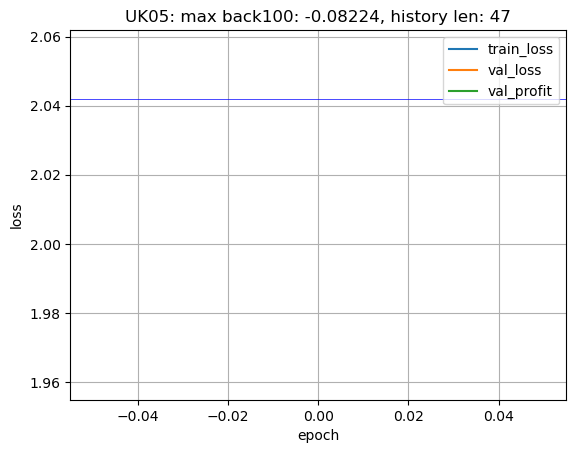

In [76]:
show_history(history, baseline=46)

In [77]:
epochs = 500;  prev_loss = float("inf")
for epoch in range(history.len(), epochs):
    start_time = time.time()

    m = 0; epoch_loss = 0.0
    n = 0; loss = tf.Variable(0.0, dtype=tf.float32); samples_seen = 0

    rambda = tf.Variable(1, dtype=tf.float32)

    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(train_batches):
        # print('train', sequence.shape)
        x = (sequence, base_bb, mask); y = base_label
        batch_loss = train_step(x, y, rambda)
        n += 1; loss = loss * (n-1) / n + batch_loss / n
        
        m += 1; epoch_loss = epoch_loss * (m-1)/m + batch_loss / m

        samples_seen += sequence.shape[0]

        if step % 50 == 0:
            show_steps(epoch, step, loss, samples_seen)
            n = 0; loss = 0.0

    show_steps(epoch, step, loss, samples_seen)
    val_loss = test_with_dataset(test_batches)
    back = back_test_with_dataset(test_batches)
    save_checkpoint(epoch_loss, val_loss, back)     #------------------------------------------- comeback

    print("epoch: {}, loss: {}, val_loss: {}, profit_eval: {}, time taken: {:.2f}s          "
          .format(epoch, float(epoch_loss), float(val_loss), float(back), (time.time() - start_time)))

epoch: 47, loss: 2.0350000858306885, val_loss: 2.0478806495666504, profit_eval: -0.08258234709501266, time taken: 717.87s          
epoch: 48, loss: 2.0247514247894287, val_loss: 2.037114381790161, profit_eval: -0.08228624612092972, time taken: 662.95s          


ValueError: math domain error